### Analysis of the classifications and markings from the SSO pipeline classifications

There were in total 3741 images from WFC3, ACS and WFPC2 used in the Asteroid Hunter project, each imaged classified by 40 users

In [406]:
import pandas as pd
import numpy as np
import os
import glob
import json
import urllib
from astropy import wcs
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord


import squarify
from PIL import Image
import PIL.ImageOps

import matplotlib.pyplot as plt
%matplotlib inline

Classifications statistics by user

The retirement limit for these images was set to = 40

             user_label  seed  nclass_user  n_gs  weight    color
0               twtunes   0.0         3791     0     1.0  #A00276
1              laverami   0.0         3748     0     1.0  #9FDF1D
2              Melina_t   0.0         3741     0     1.0  #2076C3
3             EEZuidema   0.0         3575     0     1.0  #265A50
4         MaudScientist   0.0         3123     0     1.0  #C8465F
5           ARTUROnunez   0.0         2903     0     1.0  #7DE612
6                  mwwm   0.0         2504     0     1.0  #7119C3
7         G.Roddenberry   0.0         2438     0     1.0  #846BCA
8                ShyBay   0.0         2306     0     1.0  #BF994E
9              graham_d   0.0         2149     0     1.0  #083729
10           buitrilius   0.0         2005     0     1.0  #6B4584
11              atmega8   0.0         2005     0     1.0  #19DECF
12             Chriscav   0.0         1887     0     1.0  #2BB02C
13           voyager168   0.0         1875     0     1.0  #329EDB
14        

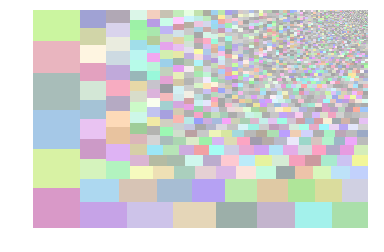

In [422]:
classifications = pd.read_csv("class_counts_colors_SSO_pipeline.csv")

#print 20 most prolific classifiers

print(classifications.head(20))

print('Mean number of classifications per user: ', np.mean(classifications["nclass_user"]))
print('Median number of classifications per user: ', np.median(classifications["nclass_user"]))
print('Maximum number of classifications per user: ', np.max(classifications["nclass_user"]))
print('Total number of classifications: ', np.sum(classifications["nclass_user"]))

def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2
    return (fair_area - area) / fair_area

print("Gini coefficient for project: %.3f" % gini(classifications['nclass_user']))

#takes a long time to run

squarify.plot(sizes=classifications["nclass_user"], color=classifications["color"], alpha=.4 )
plt.axis('off')
plt.savefig("../Plots/classification_statistics.png",dpi=300, bbox_inches="tight")
plt.show()

In [423]:
data = pd.read_csv("asteroid_SSO_classifications_markings.csv")
data=data.fillna(0)

data["total"]=data["data.impossible-to-tell"]+data["data.yes"]+data["data.no"]
data["p_yes"]=data["data.yes"]/data["total"]
data["p_no"]=data["data.no"]/data["total"]
data["p_impossible_to_tell"]=data["data.impossible-to-tell"]/data["total"]

data.loc[data["p_yes"]>=0.3, 'ast'] = 1
data.loc[data["p_yes"]<0.3, 'ast'] = 0

data.head

#data.to_csv("results_asteroids_acs_extract.csv")

/Users/skruk/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<bound method NDFrame.head of                                    filename  subject_id_1  workflow_id_1  \
0         j8xi19010_drz_1979MG3_overlay.png      34228848          10343   
1         jbhm31010_drz_1981DU2_overlay.png      34228849          10343   
2        jcm702020_drz_1981EB17_overlay.png      34228850          10343   
3        jcm703010_drz_1981EB17_overlay.png      34228851          10343   
4        jcm703020_drz_1981EB17_overlay.png      34228852          10343   
...                                     ...           ...            ...   
7477    j8pu09010_drz_Tomhockey_overlay.png      34232650          10343   
7478    jcau0mvjq_drz_Varnhagen_overlay.png      34232651          10343   
7479    jcau0mvoq_drz_Varnhagen_overlay.png      34232653          10343   
7480      j9qc06010_drz_Veritas_overlay.png      34232654          10343   
7481  ic9t28l0q_drz_vonCanstein_overlay.png      34232655          10343   

     task_1         reducer_1  data.impossible-to-tell  \

### Remove WFPC2 images ?!

Flag to remove if required images taken with the WFPC2 instrument. Upon visual inspection, these contain the vast majority of False positives (CRs identified as asteorids): 50%. These images start with the filename 'u'.

In [48]:
#data_WFPC2=data[data["INSTRUME"]=="WFPC2"]
#data=data[data["INSTRUME"]!="WFPC2"]

#print("Number of WFPC2 images: ", np.int(len(data_WFPC2)/2))
#print("Number of images remaining: ", np.int(len(data)/2))

### Select only first asteroid image

T0 - corresponds to the first question: Asteroid? Answers: Yes/No/Impossible to tell

T2 - corresponds to the second question about additional asteroids. Answers: Yes/No/Impossible to tell

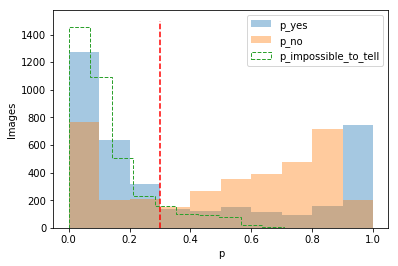

In [424]:
T0=data[data["task_1"] == "T0"]

fig, ax = plt.subplots()
alpha = 0.4
bins = 10

ax.hist(T0["p_yes"],alpha=alpha,bins=bins)
ax.hist(T0["p_no"],histtype='stepfilled',ls="-.",alpha=alpha,bins=bins)
ax.hist(T0["p_impossible_to_tell"],histtype='step',ls="--",bins=bins)
ax.legend()
ax.set_xlabel("p")
ax.set_ylabel("Images")

# set limit for images to select to p_asteroid>0.3, since there seems to be a transition around this region of the histogram

ax.plot([0.3,0.3],[0,1500],"r--")

plt.savefig("../Plots/SSO_pipeline_results.png",dpi=300, bbox_inches="tight")


### Check some example images

URLs to images are located in the "locations" column of the dataset in a JSON string

https://panoptes-uploads.zooniverse.org/production/subject_location/cdd68921-ff81-4554-a9c7-3c928d04ff8e.png


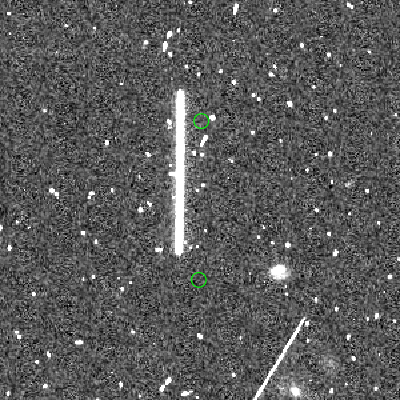

In [9]:
#take a random example of an image with p_yes>0.3

check = T0.loc[(T0["p_yes"]>0.3)].sample()

url = json.loads(check['locations'].iloc[0])

print(url['0'])

import requests
from io import BytesIO

response = requests.get(url['0'])
Image.open(BytesIO(response.content))

However, for the ease of using them and overplotting, I use the images on my drive. You can download the images from the Google Drive: 

There are 1517 images with asteroids
There is a fraction of 0.41 images with asteroids
2920    u581yh01r_c0m_2014UN144_overlay.png
Name: filename, dtype: object


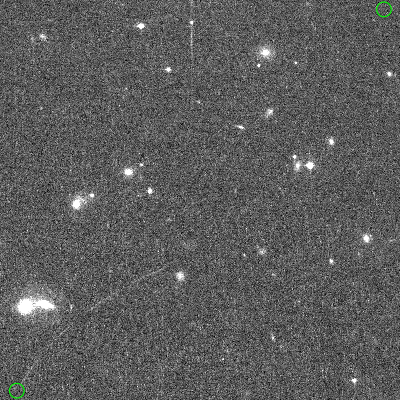

In [10]:
#replace the url to the overlay images from the SSO pipeline

base_url='/Users/skruk/Documents/ESA_citizen_science/Asteroid_finder/Dataset/zoo/wfpc2_wfc3_acs/overlay/'

check = T0.loc[(T0["p_yes"]>0.3)]

print('There are {} images with asteroids'.format(len(check)))
print('There is a fraction of {} images with asteroids'.format(np.round(len(check)/len(T0),2)))

print(check["filename"].sample())

Image.open(base_url+str(check["filename"].sample().to_string(index=False).strip()))

3500    j8pm06abq_drz_2017OU11_overlay.png
Name: filename, dtype: object


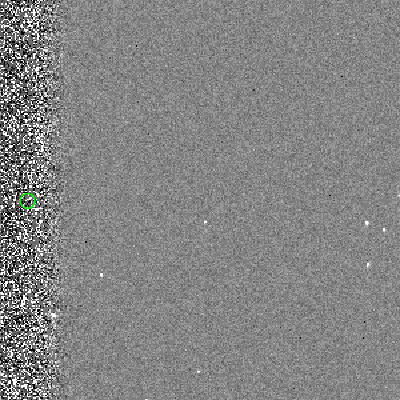

In [7]:
## check some Impossible-to-tell images

check = T0.loc[(T0["p_impossible_to_tell"]>0.2)]
print(check["filename"].sample())

Image.open(base_url+str(check["filename"].sample().to_string(index=False).strip()))

### Select images with 2 asteroids

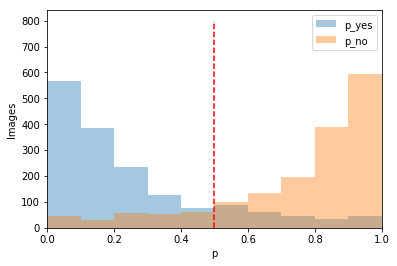

In [427]:
T2=data[(data["task_1"] == "T2") & (data["data.yes"]+data["data.no"]+data["data.impossible-to-tell"]>=10)]

fig, ax = plt.subplots()
alpha = 0.4
bins = 10

ax.hist(T2["p_yes"],alpha=alpha,bins=bins)
ax.hist(T2["p_no"],histtype='stepfilled',ls="-.",alpha=alpha,bins=bins)

ax.legend()
ax.set_xlabel("p")
ax.set_ylabel("Images")
ax.set_xlim(0,1)

ax.plot([0.5,0.5],[0,800],"r--")

plt.savefig("../Plots/SSO_pipeline_2nd_asteroid_classification_results.png",dpi=300, bbox_inches="tight")


There are 248 images with 2 asteroids
4611    j8n905011_drz_2002QZ55_overlay.png
Name: filename, dtype: object


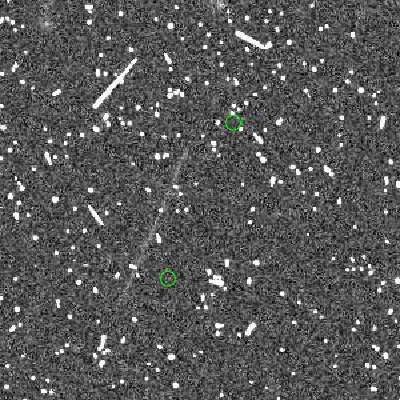

In [12]:
#Select images where at least 10 people answered the second question, otherwise there are many images where only few people said "YES" to the second question

check = T2.loc[(T2["p_yes"]>0.5) & (T2["data.yes"]+T2["data.no"]+T2["data.impossible-to-tell"]>=10)]
print('There are {} images with 2 asteroids'.format(len(check)))
print(check["filename"].sample())

Image.open(base_url+str(check["filename"].sample().to_string(index=False).strip()))

### Plot asteroid markings

### Plot all the markings for an example image

1517
Number of images with asteroids (p_ast>0.3):  1517
Fraction of images with asteroids (p_ast>0.3):  0.406


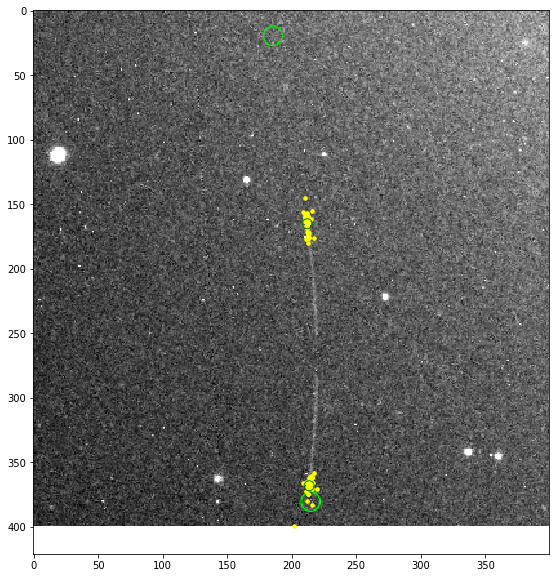

In [428]:
figsize=(10,10)
fig, ax = plt.subplots(figsize=figsize)

# select only images for which >50% of volunteers said 'yes' for asteroid trail
T0_asteroid=T0[T0["p_yes"]>0.3]
print(len(T0_asteroid))

print("Number of images with asteroids (p_ast>0.3): ",len(T0_asteroid))
print("Fraction of images with asteroids (p_ast>0.3): ",np.round(len(T0_asteroid)/len(T0),3))

ex = T0_asteroid.sample()

img = plt.imread(base_url+str(ex["filename"].to_string(index=False).strip()))
ax.imshow(img)

# plot *all* the markings
x = ex["data.frame0.T1_tool0_points_x"].iloc[0]

x1 = tuple(float(s) for s in x.strip("[]").split(","))
x2 = tuple(float(s) for s in x.strip("[]").split(","))

y = ex["data.frame0.T1_tool0_points_y"].iloc[0]

y1 = tuple(float(s) for s in y.strip("[]").split(","))
y2 = tuple(float(s) for s in y.strip("[]").split(","))

ax.scatter(x1,y1,s=10,facecolors='yellow',edgecolors='yellow')
ax.scatter(x2,y2,s=10,facecolors='yellow',edgecolors='yellow')

# plot the *clustered* markings only

x = ex["data.frame0.T1_tool0_clusters_x"].iloc[0]

x1 = tuple(float(s) for s in x.strip("[]").split(","))[0]
x2 = tuple(float(s) for s in x.strip("[]").split(","))[1]

y = ex["data.frame0.T1_tool0_clusters_y"].iloc[0]
y1 = tuple(float(s) for s in y.strip("[]").split(","))[0]
y2 = tuple(float(s) for s in y.strip("[]").split(","))[1]

ax.scatter(x1,y1,s=100,facecolors='none',edgecolors='green')
ax.scatter(x2,y2,s=100,facecolors='none',edgecolors='green')

Int64Index([   0,    8,    9,   12,   13,   14,   25,   28,   29,   31,
            ...
            3718, 3720, 3724, 3725, 3726, 3732, 3734, 3735, 3737, 3738],
           dtype='int64', length=1517)


FileNotFoundError: [Errno 2] No such file or directory: 'SSO_asteroid_markings/j8xi19010_drz_1979MG3_overlay_marked.png'

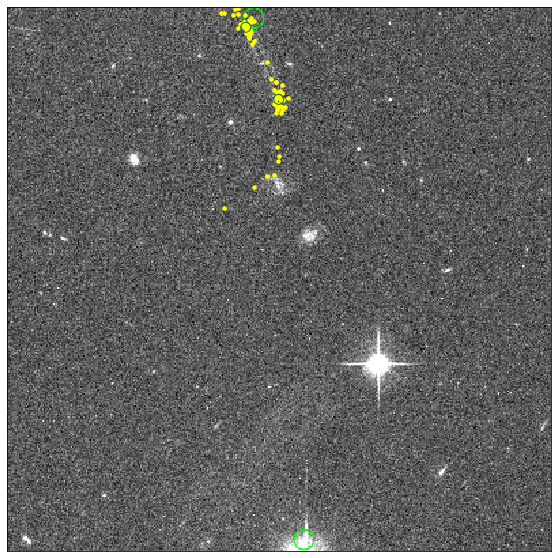

In [12]:
## Loop through all images and save the asteroid trail position in a new image. The pixel position of the markings is in the ["_points_x","_points_y"] columns. 
## Using HDBSCAN https://hdbscan.readthedocs.io/en/latest/parameter_selection.html (cluster_size=10, min_samples=10), the aggregated positions of the clusters are given in the["_cluster_x","_cluster_y"] columns 

#select all images with p_asteroid>0.3
T0_asteroid=T0[T0["p_yes"]>0.3]

ex=T0_asteroid

a=ex["data.frame0.T1_tool0_clusters_x"].index
print(a)

for i in a:
    
    #check first if file exists
    
    if os.path.isfile('../Blind_asteroid_markings/'+str(ex["filename"][i][:-4])+'_marked.png'):
                      pass
    else:   
    
        try:
            #print(ex["filename"][i])

            figsize=(10,10)
            fig, ax = plt.subplots(figsize=figsize)
            img = plt.imread(base_url+str(ex["filename"][i]))

            # plot *all* the markings
            
            x = ex["data.frame0.T1_tool0_points_x"][i]

            x1 = tuple(float(s) for s in x.strip("[]").split(","))
            x2 = tuple(float(s) for s in x.strip("[]").split(","))

            y = ex["data.frame0.T1_tool0_points_y"][i]

            y1 = tuple(float(s) for s in y.strip("[]").split(","))
            y2 = tuple(float(s) for s in y.strip("[]").split(","))

            ax.scatter(x1,y1,s=10,facecolors='yellow',edgecolors='yellow')
            ax.scatter(x2,y2,s=10,facecolors='yellow',edgecolors='yellow')

            # plot the *clustered* markings only. In general, there should be 2 clustered positions only. 

            x = ex["data.frame0.T1_tool0_clusters_x"][i]

            x1 = tuple(float(s) for s in x.strip("[]").split(","))[0]
            x2 = tuple(float(s) for s in x.strip("[]").split(","))[1]

            y = ex["data.frame0.T1_tool0_clusters_y"][i]
            y1 = tuple(float(s) for s in y.strip("[]").split(","))[0]
            y2 = tuple(float(s) for s in y.strip("[]").split(","))[1]

            ax.scatter(x1,y1,s=100,facecolors='none',edgecolors='green')
            ax.scatter(x2,y2,s=100,facecolors='none',edgecolors='green')

            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

            ax.imshow(img)
            
            plt.savefig("../SSO_asteroid_markings/"+str(ex["filename"][i][:-4])+"_marked.png", dpi=200, bbox_inches='tight')

            #except used when no or only 1 cluster is identified (not enough points to aggregate into a cluster)
        except AttributeError: 

            print(i)

            figsize=(10,10)
            fig, ax = plt.subplots(figsize=figsize)
            img = plt.imread(base_url+str(ex["filename"][i]))

            # plot *all* the markings
            x = ex["data.frame0.T1_tool0_points_x"][i]

            x1 = tuple(float(s) for s in x.strip("[]").split(","))
            x2 = tuple(float(s) for s in x.strip("[]").split(","))

            y = ex["data.frame0.T1_tool0_points_y"][i]

            y1 = tuple(float(s) for s in y.strip("[]").split(","))
            y2 = tuple(float(s) for s in y.strip("[]").split(","))

            ax.scatter(x1,y1,s=10,facecolors='yellow',edgecolors='yellow')
            ax.scatter(x2,y2,s=10,facecolors='yellow',edgecolors='yellow')

            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

            ax.imshow(img)
            plt.savefig("../SSO_asteroid_markings/"+str(ex["filename"][i][:-4])+"_marked.png", dpi=200, bbox_inches='tight')

### Plot clustered points only

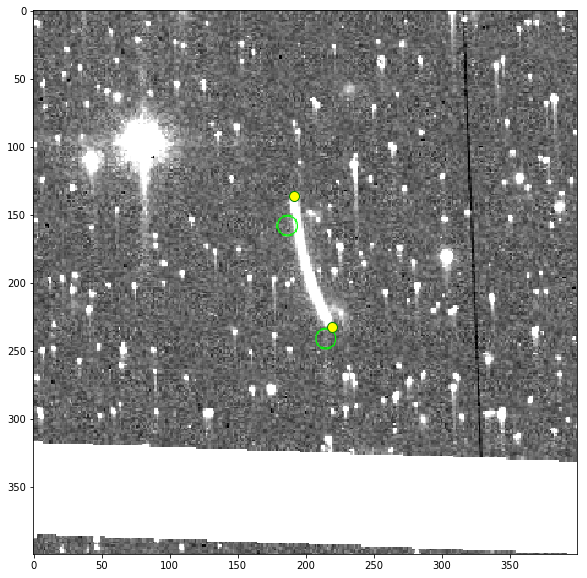

In [14]:
figsize=(10,10)
fig, ax = plt.subplots(figsize=figsize)

T0_asteroid=T0[T0["p_yes"]>0.5]

ex = T0_asteroid.sample()

img = plt.imread(base_url+str(ex["filename"].to_string(index=False).strip()))
ax.imshow(img)

x = ex["data.frame0.T1_tool0_clusters_x"].iloc[0]

x1 = tuple(float(s) for s in x.strip("[]").split(","))[0]
x2 = tuple(float(s) for s in x.strip("[]").split(","))[1]

y = ex["data.frame0.T1_tool0_clusters_y"].iloc[0]
y1 = tuple(float(s) for s in y.strip("[]").split(","))[0]
y2 = tuple(float(s) for s in y.strip("[]").split(","))[1]

ax.scatter(x1,y1,s=100,facecolors='yellow',edgecolors='green')
ax.scatter(x2,y2,s=100,facecolors='yellow',edgecolors='green')

### Images with a second asteroid

We need to use the T2 & T3 questions for the second asteroid trail

Number of images with >1 asteroid trail is  248


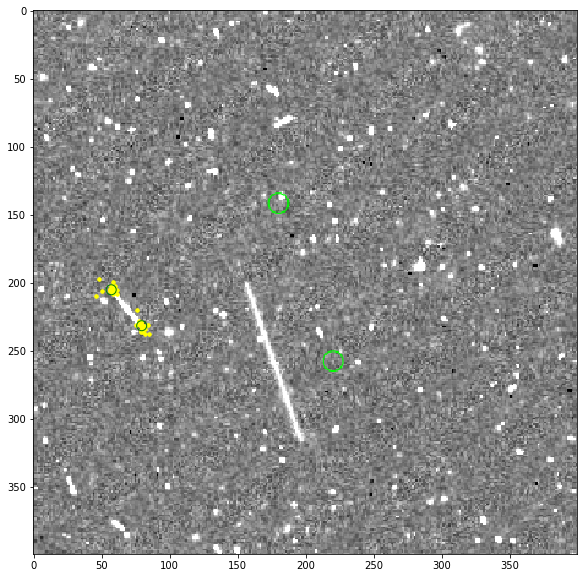

In [15]:
#select a more conservative limit for the second asteroid trail, p_asteroid>0.5, again at least 10 people to answer the second question

T2_asteroid=T2[(T2["p_yes"]>0.5) & (T2["data.yes"]+T2["data.no"]+T2["data.impossible-to-tell"]>=10)]

print('Number of images with >1 asteroid trail is ', len(T2_asteroid))

figsize=(10,10)
fig, ax = plt.subplots(figsize=figsize)

#print random example

ex = T2_asteroid.sample()

img = plt.imread(base_url+str(ex["filename"].to_string(index=False).strip()))
ax.imshow(img)

# plot *all* the markings
x = ex["data.frame0.T3_tool0_points_x"].iloc[0]

x1 = tuple(float(s) for s in x.strip("[]").split(","))
x2 = tuple(float(s) for s in x.strip("[]").split(","))

y = ex["data.frame0.T3_tool0_points_y"].iloc[0]

y1 = tuple(float(s) for s in y.strip("[]").split(","))
y2 = tuple(float(s) for s in y.strip("[]").split(","))

ax.scatter(x1,y1,s=10,facecolors='yellow',edgecolors='yellow')
ax.scatter(x2,y2,s=10,facecolors='yellow',edgecolors='yellow')

# plot the *clustered* markings only

x = ex["data.frame0.T3_tool0_clusters_x"].iloc[0]

x1 = tuple(float(s) for s in x.strip("[]").split(","))[0]
x2 = tuple(float(s) for s in x.strip("[]").split(","))[1]

y = ex["data.frame0.T3_tool0_clusters_y"].iloc[0]
y1 = tuple(float(s) for s in y.strip("[]").split(","))[0]
y2 = tuple(float(s) for s in y.strip("[]").split(","))[1]

ax.scatter(x1,y1,s=100,facecolors='none',edgecolors='green')
ax.scatter(x2,y2,s=100,facecolors='none',edgecolors='green')

Save files with 2 asteroids marked

248
ic1905taq_drz_1981UW23_overlay.png 1.0


FileNotFoundError: [Errno 2] No such file or directory: 'SSO_asteroid_markings/ic1905taq_drz_1981UW23_overlay_marked_2.png'

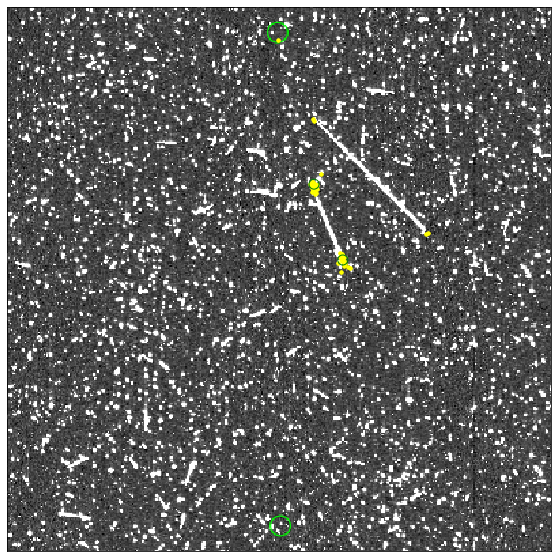

In [16]:
## Loop through all images and save the asteroid trail position

#select all images with p_asteroid>0.5 & at least 10 votes for the 2nd question

T2_asteroid=T2[(T2["p_yes"]>0.5) & (T2["data.yes"]+T2["data.no"]+T2["data.impossible-to-tell"]>=10)]

ex=T2_asteroid

a=ex["data.frame0.T3_tool0_clusters_x"].index
print(len(ex))

for i in a:
    
        #check first if file exists
    
    if os.path.isfile('../Blind_asteroid_markings/'+str(ex["filename"][i][:-4])+'_marked.png'):
                      pass
    else:   
        try:
            print(ex["filename"][i],ex["p_yes"][i])

            figsize=(10,10)
            fig, ax = plt.subplots(figsize=figsize)
            img = plt.imread(base_url+str(ex["filename"][i]))

            # plot *all* the markings
            
            x = ex["data.frame0.T3_tool0_points_x"][i]

            x1 = tuple(float(s) for s in x.strip("[]").split(","))
            x2 = tuple(float(s) for s in x.strip("[]").split(","))

            y = ex["data.frame0.T3_tool0_points_y"][i]

            y1 = tuple(float(s) for s in y.strip("[]").split(","))
            y2 = tuple(float(s) for s in y.strip("[]").split(","))

            ax.scatter(x1,y1,s=10,facecolors='yellow',edgecolors='yellow')
            ax.scatter(x2,y2,s=10,facecolors='yellow',edgecolors='yellow')

            # plot the *clustered* markings only

            x = ex["data.frame0.T3_tool0_clusters_x"][i]

            x1 = tuple(float(s) for s in x.strip("[]").split(","))[0]
            x2 = tuple(float(s) for s in x.strip("[]").split(","))[1]

            y = ex["data.frame0.T3_tool0_clusters_y"][i]
            y1 = tuple(float(s) for s in y.strip("[]").split(","))[0]
            y2 = tuple(float(s) for s in y.strip("[]").split(","))[1]

            ax.scatter(x1,y1,s=100,facecolors='none',edgecolors='green')
            ax.scatter(x2,y2,s=100,facecolors='none',edgecolors='green')

            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

            ax.imshow(img)
            plt.savefig("../SSO_asteroid_markings/"+str(ex["filename"][i][:-4])+"_marked_2.png", dpi=200, bbox_inches='tight')

        except (AttributeError): 

            print(i,ex["p_yes"][i])

            figsize=(10,10)
            fig, ax = plt.subplots(figsize=figsize)
            img = plt.imread(base_url+str(ex["filename"][i]))

            # plot *all* the markings
            x = ex["data.frame0.T3_tool0_points_x"][i]

            x1 = tuple(float(s) for s in x.strip("[]").split(","))
            x2 = tuple(float(s) for s in x.strip("[]").split(","))

            y = ex["data.frame0.T3_tool0_points_y"][i]

            y1 = tuple(float(s) for s in y.strip("[]").split(","))
            y2 = tuple(float(s) for s in y.strip("[]").split(","))

            ax.scatter(x1,y1,s=10,facecolors='yellow',edgecolors='yellow')
            ax.scatter(x2,y2,s=10,facecolors='yellow',edgecolors='yellow')

            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

            ax.imshow(img)
            plt.savefig("../SSO_asteroid_markings/"+str(ex["filename"][i][:-4])+"_marked_2.png", dpi=200, bbox_inches='tight')

Find the **good** images with asteroid trails (quick inspection to remove cosmic rays)

/Users/skruk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(array([4816.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2666.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

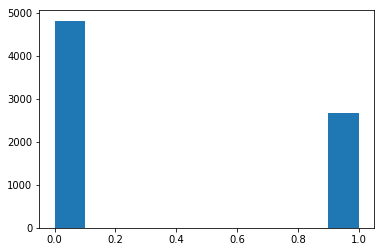

In [17]:
data["asteroid"]=0

for file_name in glob.glob("../SSO_asteroid_markings/Good/*.png"):
    file=file_name.split('/')[3][:-11]+".png"
    for i in range(0,len(data)):
        if data["filename"].iloc[i]==file:
            data["asteroid"].iloc[i]=1
            #copy the "Good" images into a different folder
            
            #os.system("cp -r /Users/skruk/Documents/ESA_citizen_science/Asteroid_finder/Dataset/zoo/wfpc2_wfc3_acs/cutouts/"+str(data["filename"][i][:-12])+".png Asteroids/"+str(data["filename"][i][:-12])+".png")
plt.hist(data["asteroid"])

In [64]:
# Copy *all* images to a different folder

#for i in range(0,len(data)):
#    os.system("cp -r /Users/skruk/Documents/ESA_citizen_science/Asteroid_finder/Dataset/zoo/wfpc2_wfc3_acs/cutouts/"+str(data["filename"][i][:-12])+".png No_asteroid_trails/"+str(data["filename"][i][:-12])+".png")

SyntaxError: unexpected EOF while parsing (<ipython-input-64-58ab71b1bd14>, line 4)

In [159]:
# Create "clean" sample of images without asteroids (p_asteroids<0.1) for a training sample

data_no=data[(data["task_1"] == "T0") & (data["p_yes"]<0.1)]
print(data_no.head)
plt.hist(data_no["p_yes"])

for i in range(0,len(data_no)):
#    os.system("cp -r /Users/skruk/Documents/ESA_citizen_science/Asteroid_finder/Dataset/zoo/wfpc2_wfc3_acs/cutouts/"+str(data_no["filename"].iloc[i][:-12])+".png No_asteroids_clean/"+str(data_no["filename"].iloc[i][:-12])+".png")

SyntaxError: unexpected EOF while parsing (<ipython-input-159-d08d539e919a>, line 8)

### Evaluate citizen scientists output

Compute the aggregated (x,y) positions of the markings in the original HST FITS images

In [253]:
#For the images with the identified asteroids only:

data["orig_x"]=[]
data["orig_y"]=[]


# For each image, for each match, compute the pixel position in the original image
for ind, img in data.iterrows():

        # Find the offset between cutout and original in the metadata file

        try:
            off_x, off_y = data['ORIGIN_ORIGINAL'].tolist()[0].split(',')
        except IndexError:
            print('Could not find:')
            print(obs_id, level, sso, end='\n\n')
            continue#sys.exit()


        scale = 400 / float(data['CUTOUT_SIZE'].tolist()[0])

        if (data["asteroid"][ind]==1) & (data["task_1"][ind]=="T0"):
            try:    

                x_positions = data['data.frame0.T1_tool0_clusters_x'][ind].strip('[').strip(']').split(', ')
                y_positions = data['data.frame0.T1_tool0_clusters_y'][ind].strip('[').strip(']').split(', ')
                

                cut_x = [float(off_x)+float(i)/scale for i in x_positions]
                cut_y = [float(off_y)+float(i)/scale for i in y_positions]

                data["orig_x"][ind]=np.asarray(cut_x,dtype=object)
                data["orig_y"][ind]=np.asarray(cut_y,dtype=object)

            # When no clusters are found

            except AttributeError: 
                x_positions=[]
                y_positions=[]
                data["orig_x"][ind]=[]
                data["orig_y"][ind]=[]
                pass
            
        elif (data["asteroid"][ind]==1) & (data["task_1"][ind]=="T2"):
            try:    

                x_positions = data['data.frame0.T3_tool0_clusters_x'][ind].strip('[').strip(']').split(', ')
                y_positions = data['data.frame0.T3_tool0_clusters_y'][ind].strip('[').strip(']').split(', ')

                cut_x = [float(off_x)+float(i)/scale for i in x_positions]
                cut_y = [float(off_y)+float(i)/scale for i in y_positions]

                data["orig_x"][ind]=np.asarray(cut_x,dtype=object)
                data["orig_y"][ind]=np.asarray(cut_y,dtype=object)

            # When no clusters are found

            except AttributeError: 
                x_positions=[]
                y_positions=[]
                data["orig_x"][ind]=[]
                data["orig_y"][ind]=[]
                pass            

/Users/skruk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/skruk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/skruk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/skruk/anaconda3/lib/pyth

Compute the (ra,dec) positions of the *observed* asteroid trail (taken from evaluate_citize_input.py file)

In [294]:
data['sso_name'] = data['sso_name'].apply(lambda x: x.replace(' ', ''))

data["orig_ra"]=0
data["orig_dec"]=0

for ind, line in data.iterrows():
    
    try:

        # Derive the ROOTNAME, CALIBRATION_LEVEL and SSO_NAME from the cutout
        rootname, calib_level, sso_name, _ = line.filename.split('_')

        cutout_wcs = data[(data.sso_name == sso_name) &
                                 (data.ROOTNAME == rootname) &
                                 (data.CALIB_LEVEL == calib_level)]

        # ------
        # Setup cutout image WCS
        w = wcs.WCS(naxis=2)
        w.wcs.crpix  = [cutout_wcs['CRPIX1'].values[0], cutout_wcs['CRPIX2'].values[0]] 
        w.wcs.cdelt  = [cutout_wcs['CDELT1'].values[0], cutout_wcs['CDELT2'].values[0]]
        w.wcs.crval  = [cutout_wcs['CRVAL1'].values[0], cutout_wcs['CRVAL2'].values[0]]
        w.wcs.ctype  = [cutout_wcs['CTYPE1'].values[0], cutout_wcs['CTYPE2'].values[0]]
        w.wcs.pc = [(cutout_wcs['PC1_1'].values[0], cutout_wcs['PC1_2'].values[0]),
                    (cutout_wcs['PC2_1'].values[0], cutout_wcs['PC2_2'].values[0])]

        # ------
        # Convert the user pixel input to WCS

        #added a scaling between the png and fits images, the pixel scale is different in the two images! 
        
        x_positions = data['data.frame0.T1_tool0_clusters_x'][ind].strip('[').strip(']').split(', ')
        x1,x2=float(x_positions[0]),float(x_positions[1])
        y_positions = data['data.frame0.T1_tool0_clusters_y'][ind].strip('[').strip(']').split(', ')
        y1,y2=float(y_positions[0]),float(y_positions[1])      
                
        scale= 400 / float(cutout_wcs['CUTOUT_SIZE'].tolist()[0])
        #print(scale)
        world_1 = w.wcs_pix2world(np.array([[x1*scale, y1*scale]], np.float_), 1)
        ra_1, dec_1 = world_1[0]

        world_2 = w.wcs_pix2world(np.array([[x2*scale, y2*scale]], np.float_), 1)
        ra_2, dec_2 = world_2[0]
        
        ra=[ra_1,ra_2]
        dec=[dec_1,dec_2]
        #print('SSO %s was observed at (%.6f, %.6f) and (%.6f, %.6f) in %s/%s' %\
                #(sso_name, ra_1, dec_1, ra_2, dec_2, rootname, calib_level))
        data["orig_ra"].iloc[ind]=np.asarray(ra,dtype=object)
        data["orig_dec"].iloc[ind]=np.asarray(dec,dtype=object)
        
    except (IndexError,ValueError,AttributeError):
        #in the case of images without asteroids pass
        pass
print(data["orig_ra"])
#SAVE OUTPUT TO A NEW FILE
data.to_csv("asteroid_SSO_classifications_markings_original.csv")

/Users/skruk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0       [149.811933934735, 149.81219446950413]
1                                            0
2                                            0
3                                            0
4                                            0
                         ...                  
7477                                         0
7478                                         0
7479                                         0
7480                                         0
7481                                         0
Name: orig_ra, Length: 7482, dtype: object


## Derive some statistics of the recovered asteroids 

The magnitude of the recovered asteroids

/Users/skruk/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21,22,23,138,139) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


No. of images with detected asteroids: 1333
No. of images with non-detected asteroids: 2408


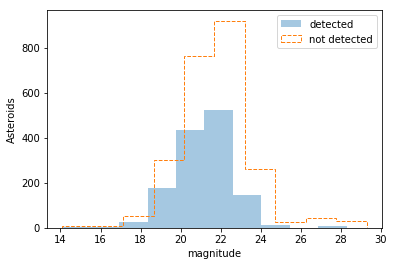

In [429]:
#read in the last saved table with astropy
data=pd.read_csv("asteroid_SSO_classifications_markings_original.csv")

# select only the clean asteroid images and the first task T0
asteroids = data[(data["asteroid"]==1) & (data["task_1"]=="T0")]
no_asteroids = data[(data["asteroid"]==0) & (data["task_1"]=="T0")]

print("No. of images with detected asteroids:", len(asteroids))
print("No. of images with non-detected asteroids:", len(no_asteroids))
#plot the V-band magnitude of the recovered asteroids

fig, ax = plt.subplots()
alpha = 0.4
bins = 10

ax.hist(asteroids["v_mag_1"],alpha=alpha,bins=bins,label='detected')
ax.hist(no_asteroids["v_mag_1"],histtype='step',ls="--",bins=bins,label='not detected')
ax.legend()
ax.set_xlabel("magnitude")
ax.set_ylabel("Asteroids")

plt.savefig("../Plots/SSO_pipeline_magnitude.png",dpi=300, bbox_inches="tight")

The length of the recovered trails

/Users/skruk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/skruk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/skruk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

No clusters identified: 63 [1445.0] [625.0]
No clusters identified: 68 [1445.0] [625.0]
No clusters identified: 131 [1445.0] [625.0]
No clusters identified: 133 [1445.0] [625.0]
No clusters identified: 302 [1445.0] [625.0]
No clusters identified: 694 [1445.0] [625.0]
No clusters identified: 877 [1445.0] [625.0]
No clusters identified: 887 [1445.0] [625.0]
No clusters identified: 917 [1445.0] [625.0]
No clusters identified: 1236 [1445.0] [625.0]
No clusters identified: 1709 [1445.0] [625.0]
No clusters identified: 1743 [1445.0] [625.0]
No clusters identified: 1857 [1445.0] [625.0]
No clusters identified: 1906 [1445.0] [625.0]
No clusters identified: 2013 [1445.0] [625.0]
No clusters identified: 2132 [1445.0] [625.0]
No clusters identified: 2159 [1445.0] [625.0]
No clusters identified: 2237 [1445.0] [625.0]
No clusters identified: 2567 [1445.0] [625.0]
No clusters identified: 3212 [1445.0] [625.0]
No clusters identified: 3687 [2174.7760264249946 2102.3162390814887] [1458.1852085993842 12

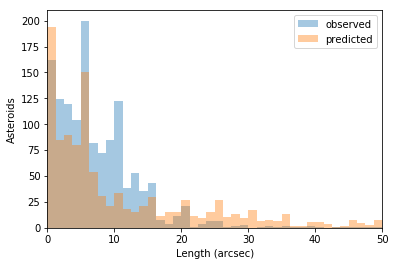

In [430]:
# compute first the length of the recovered trails in the original HST frames in pixels
asteroids["length_pix"]=0
asteroids["length_arcsec"]=0
asteroids["observed_trail_arcsec"]=0
asteroids["predicted_trail_arcsec"]=0

for i,value in asteroids.iterrows():
    try: 
        x1=float(asteroids["orig_x"][i].strip('[').strip(']').split(' ')[0])
        x2=float(asteroids["orig_x"][i].strip('[').strip(']').split(' ')[1])

        y1=float(asteroids["orig_y"][i].strip('[').strip(']').split(' ')[0])
        y2=float(asteroids["orig_y"][i].strip('[').strip(']').split(' ')[1])

        asteroids["length_pix"][i]=np.sqrt((x1-x2)**2+(y1-y2)**2)
        
        if asteroids["INSTRUME"][i]=="ACS":
            asteroids["length_arcsec"][i] = asteroids["length_pix"][i]*0.05

        if (asteroids["INSTRUME"][i]=="WFC3") & (asteroids["DETECTOR"][i]=="UVIS"):
            asteroids["length_arcsec"][i] = asteroids["length_pix"][i]*0.04
        
        if (asteroids["INSTRUME"][i]=="WFC3") & (asteroids["DETECTOR"][i]=="IR"):
            asteroids["length_arcsec"][i] = asteroids["length_pix"][i]*0.13
            
        if asteroids["INSTRUME"][i]=="WFPC2":
            asteroids["length_arcsec"][i] = asteroids["length_pix"][i]*0.046
            
        ra_1 = float(asteroids["orig_ra"][i].strip('[').strip(']').split(' ')[0])
        ra_2 = float(asteroids["orig_ra"][i].strip('[').strip(']').split(' ')[1])
        
        dec_1 = float(asteroids["orig_dec"][i].strip('[').strip(']').split(' ')[0])
        dec_2 = float(asteroids["orig_dec"][i].strip('[').strip(']').split(' ')[1])
        
        #Calculate observed trail length
        
        c1=SkyCoord(ra_1*u.deg,dec_1*u.deg, frame='icrs')
        c2=SkyCoord(ra_2*u.deg,dec_2*u.deg, frame='icrs')
        sep = c1.separation(c2)
        asteroids["observed_trail_arcsec"][i]=sep.arcsecond
        
        #Calculate predicted trail length
        
        c1=SkyCoord(asteroids["ra_deg_1"][i]*u.deg,asteroids["dec_deg_1"][i]*u.deg, frame='icrs')
        c2=SkyCoord(asteroids["ra_deg_2"][i]*u.deg,asteroids["dec_deg_2"][i]*u.deg, frame='icrs')
        sep = c1.separation(c2)
        asteroids["predicted_trail_arcsec"][i]=sep.arcsecond
        
        
        
            
    except (ValueError,IndexError):
         asteroids["length_pix"][i]=0
         asteroids["length_arcsec"][i]=0
         print("No clusters identified:", i, data["orig_x"].iloc[i],data["orig_y"].iloc[i])
         pass
 
#then convert the pixel length to arcseconds (what is the pixel scale of the WFC3, ACS and WFPC2 images)?! - use 0.05 for now

#asteroids["length_arcsec"] = asteroids["length_pix"]*0.05
#print(asteroids["length_pix"])
    
#plot the V-band magnitude of the recovered asteroids

fig, ax = plt.subplots()
alpha = 0.4
bins = 40

ax.hist(asteroids["observed_trail_arcsec"],alpha=alpha,bins=bins,range=(0,50),label='observed')
ax.hist(asteroids["predicted_trail_arcsec"],alpha=alpha,bins=bins,range=(0,50),label='predicted')
#ax.hist(no_asteroids["v_mag_1"],histtype='step',ls="--",bins=bins,label='not detected')
ax.set_xlim(0,50)
ax.legend()
ax.set_xlabel("Length (arcsec)")
ax.set_ylabel("Asteroids")

plt.savefig("../Plots/SSO_pipeline_trail_length.png",dpi=300, bbox_inches="tight")

Text(0, 0.5, 'Observed Trail Length (arcsec)')

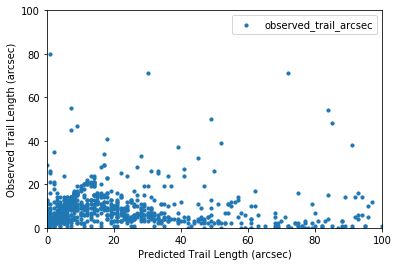

In [328]:
fig, ax = plt.subplots()

ax.scatter(asteroids["predicted_trail_arcsec"],asteroids["observed_trail_arcsec"],s=10)
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.legend()
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("Predicted Trail Length (arcsec)")
ax.set_ylabel("Observed Trail Length (arcsec)")

Text(0, 0.5, 'Asteroids')

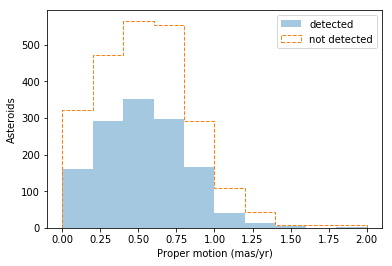

In [351]:
#plot the speed of the recovered vs non-recovered asteroids

fig, ax = plt.subplots()
alpha = 0.4
bins = 10

ax.hist(asteroids["PM/mas/yr"],alpha=alpha,bins=bins,range=(0,2),label='detected')
ax.hist(no_asteroids["PM/mas/yr"],histtype='step',ls="--",bins=bins,range=(0,2),label='not detected')
ax.legend()
ax.set_xlabel("Proper motion (mas/yr)")
ax.set_ylabel("Asteroids")

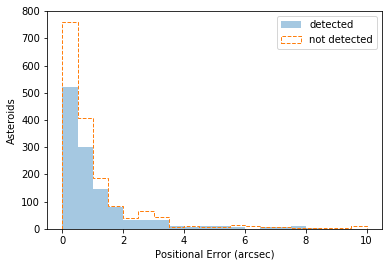

In [431]:
#plot the speed of the recovered vs non-recovered asteroids

fig, ax = plt.subplots()
alpha = 0.4
bins = 20

ax.hist(asteroids["pos1_deg_err"]*3600,alpha=alpha,bins=bins,range=(0,10),label='detected')
ax.hist(no_asteroids["pos1_deg_err"]*3600,histtype='step',ls="--",bins=bins,range=(0,10),label='not detected')
ax.legend()
ax.set_xlabel("Positional Error (arcsec)")
ax.set_ylabel("Asteroids")

plt.savefig("../Plots/SSO_positional_error.png",dpi=300, bbox_inches="tight")

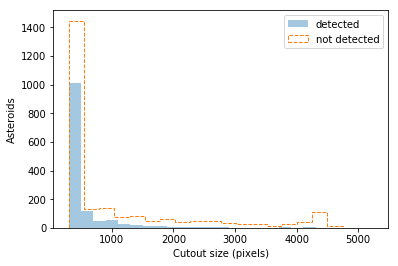

In [432]:
fig, ax = plt.subplots()
alpha = 0.4
bins = 20

ax.hist(asteroids["CUTOUT_SIZE"],alpha=alpha,bins=bins,label='detected')
ax.hist(no_asteroids["CUTOUT_SIZE"],histtype='step',ls="--",bins=bins,label='not detected')
ax.legend()
ax.set_xlabel("Cutout size (pixels)")
ax.set_ylabel("Asteroids")

plt.savefig("../Plots/SSO_pipeline_cutout_size.png",dpi=300, bbox_inches="tight")

68
1                jbhm31010_drz_1981DU2_overlay.png
2               jcm702020_drz_1981EB17_overlay.png
3               jcm703010_drz_1981EB17_overlay.png
4               jcm703020_drz_1981EB17_overlay.png
5               jcm704010_drz_1981EB17_overlay.png
6               jcm704020_drz_1981EB17_overlay.png
19              jcln07010_drz_1991RJ22_overlay.png
81               icp013010_drz_1998EW2_overlay.png
83               icp013030_drz_1998EW2_overlay.png
120              jczg01010_drz_1999AF8_overlay.png
148             ic3f49040_drz_1999JP88_overlay.png
149             ic3f50030_drz_1999JP88_overlay.png
301             j9np03010_drz_2000EV97_overlay.png
347              jbyj18020_drz_2000LJ1_overlay.png
388             ia21j2010_drz_2000RT52_overlay.png
396            jbts24020_drz_2000SG287_overlay.png
432             icnw24070_drz_2000WE36_overlay.png
434             icnw24090_drz_2000WE36_overlay.png
505             jbqp04020_drz_2001OO37_overlay.png
526             u8w8hc02m_c0

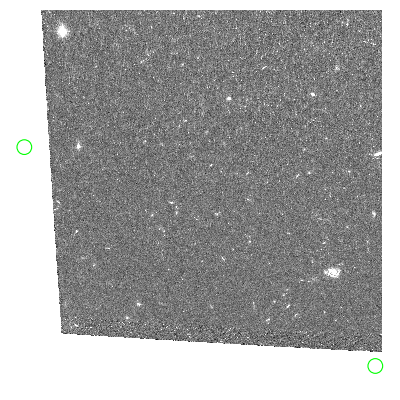

In [437]:
#select brightest asteroids with lowest positional error to inspect why the asteroid is not there.
check = no_asteroids[(no_asteroids["v_mag_1"]<20) & (no_asteroids["pos2_deg_err"]*3600<0.1)]
print(len(check))
print(check.filename.to_string())

Image.open(base_url+str(check["filename"].sample().to_string(index=False).strip()))

#Image.open(base_url+"ic2i10030_drz_Pesch_overlay.png")